https://github.com/groovybob/Clusters

http://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_gaia_source.html

http://localhost:8888/notebooks/Gaia_astroquery_tutorial_clusters.ipynb

http://spiff.rit.edu/classes/ladder/lectures/parallax/parallax.html

In [1]:
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [2]:
import astropy.units as u
import gzip
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
from scipy.stats import kde
import matplotlib as mpl
import os
import time
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statistics import median
from math import *
import starcolorindexSpT
import starcolorindexTeff

from pprint import pprint

import scipy as sp

print("\nInitialized!")

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443

Initialized!


In [3]:
# Add timing functions to measure how long database queries take.

from datetime import datetime

def timer_start():
  global start_time
  start_time = datetime.now()

def timer_stop():
  time_elapsed = datetime.now() - start_time

  da, remainder  = divmod(time_elapsed.total_seconds(), 24*3600)
  hrs, remainder = divmod(remainder, 3600)
  mins, secs = divmod(remainder, 60)

  if da:
      print(f'{int(da)} days {int(hrs)} hours {int(mins)} minutes {int(secs)} seconds elapsed')
  elif hrs:
      print(f'{int(hrs)} hours {int(mins)} minutes {int(secs)} seconds elapsed')
  elif mins:
      print(f'{int(mins)} minutes {int(secs)} seconds elapsed')
  elif secs >= 1.0:
      print(f'{int(secs)} seconds elapsed')
  else:
      print(f'{secs:.2} seconds elapsed')
        
print('timer functions loaded')

timer functions loaded


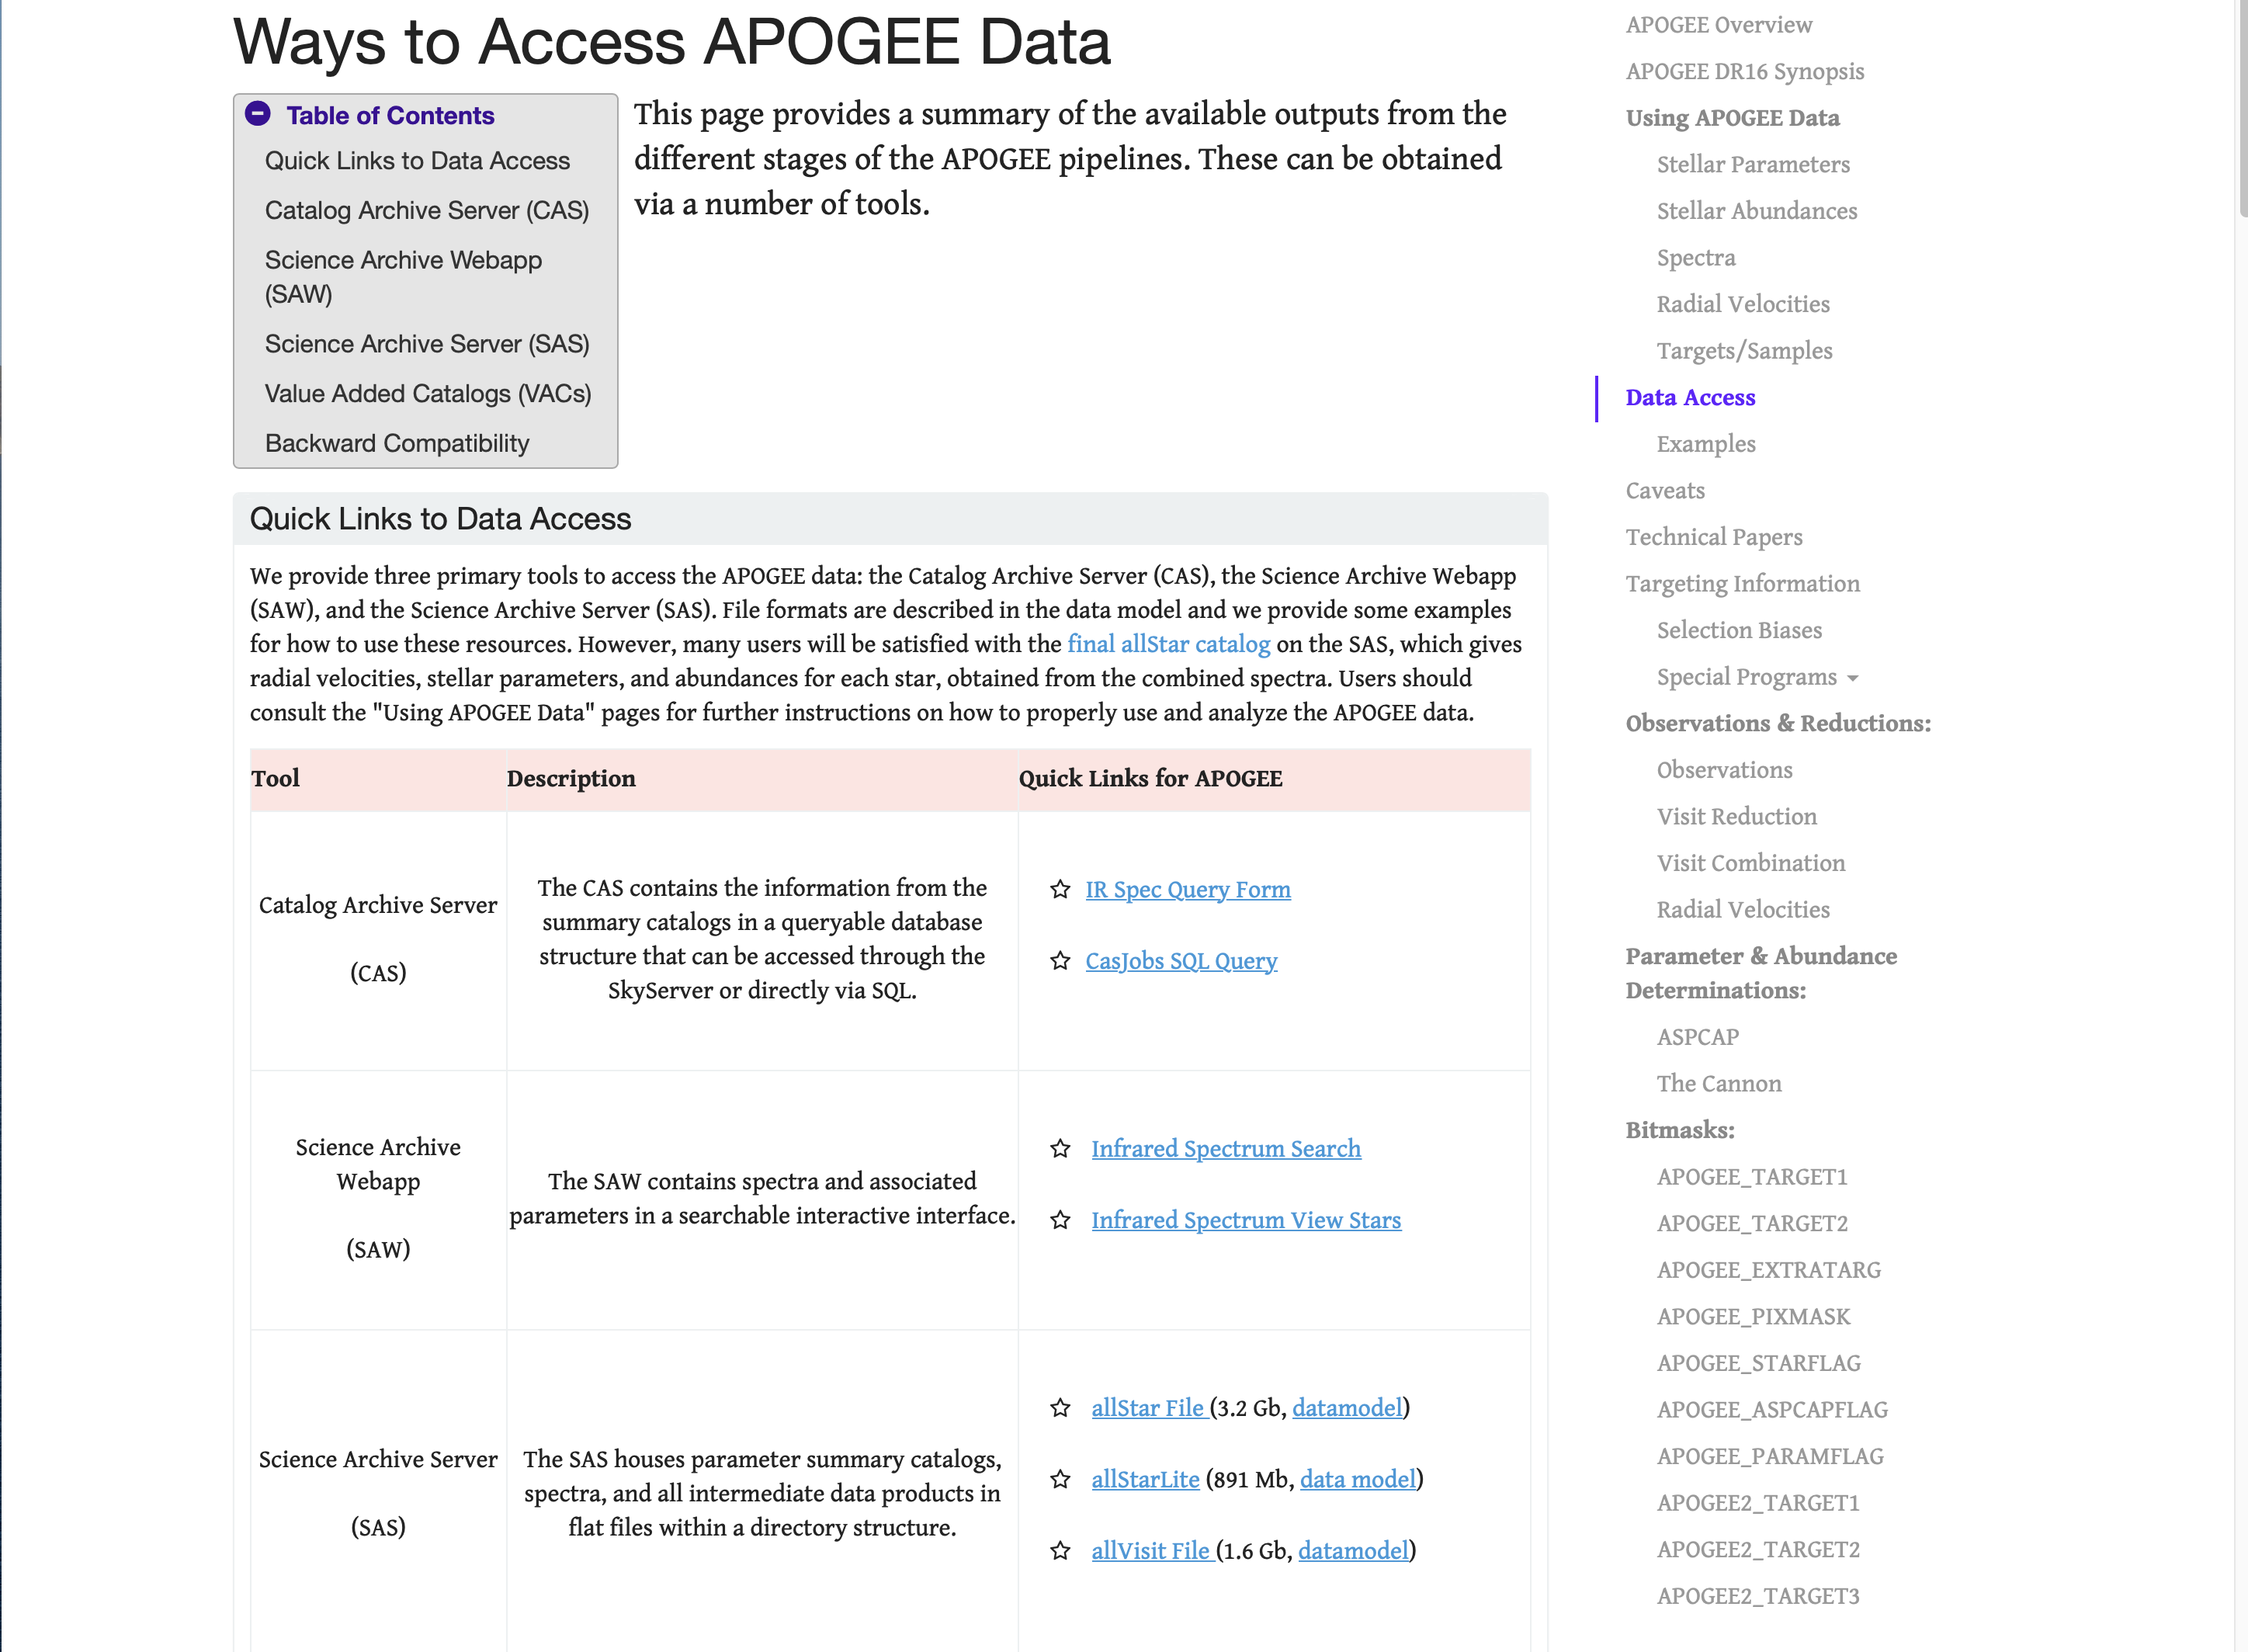




In [ ]:
# Download allStarLite from above https://www.sdss.org/dr16/irspec/spectro_data/

# Open FITS file in Tomcat.

# Save as CSV file       <<<<<<<< ##################################

In [19]:

df_Apogee = pd.read_csv('allStarLite-r12-133.csv')

df_Apogee['BP_RP']   = df_Apogee['GAIA_PHOT_BP_MEAN_MAG']  - df_Apogee['GAIA_PHOT_RP_MEAN_MAG']
df_Apogee['SpT2'] = df_Apogee.apply(lambda row: starcolorindexSpT.subclass[round(row.BP_RP, 2)], axis=1)
df_Apogee['Parsec'] =  abs(((1 / df_Apogee['GAIA_PARALLAX']) * 1000))
df_Apogee['LY'] = abs(3261.56/df_Apogee['GAIA_PARALLAX'])

# calculate absolute magnitude and add a new column (M)
df_Apogee['M'] = df_Apogee['GAIA_PHOT_G_MEAN_MAG'] + 5*np.log10(df_Apogee['GAIA_PARALLAX']) - 10
#df_Apogee['M'].describe()

# add a new column ('L_sun') for luminosity in terms of multiples of solar luminosity
df_Apogee['L_sun'] = np.power(10,[(4.77-m)/2.5 for m in df_Apogee['M']])

# add a new column ('T_K') for effective temperature in Kelvin
df_Apogee['T_K'] = [5601/np.power(c+0.4,2/3) for c in df_Apogee['BP_RP']]

df_Apogee['R_sun']=np.around(np.sqrt(df_Apogee['L_sun'])/(df_Apogee['T_K']/5800)**2, decimals=2) # T_☉ = 5800

print("\nDone!")


Done!


In [20]:
conditions = [
    (df_Apogee['LOGG'].astype(float) > 4.20),
    ((df_Apogee['LOGG'].astype(float) <= 4.20) & (df_Apogee['LOGG'].astype(float) > 3.90)),
    ((df_Apogee['LOGG'].astype(float) <= 3.90) & (df_Apogee['LOGG'].astype(float) > 3.60)),
    ((df_Apogee['LOGG'].astype(float) < 2.55) & (df_Apogee['LOGG'].astype(float) > 2.35)),
    (df_Apogee['LOGG'].astype(float) <= 3.60)
]

values = ['main_sequence', 'turnoff', 'subgiants', 'red_clump', 'red_giants']

df_Apogee['Star_Type'] = np.select(conditions, values)

print("\nDone!")


Done!


In [21]:
df_red_giants = df_Apogee[df_Apogee.Star_Type == 'red_giants']
df_red_giants.shape[0]

250918

In [22]:
red_giants_fields = sp.unique(df_red_giants.FIELD)

In [23]:
for field in red_giants_fields:
    R = df_red_giants[df_red_giants.FIELD == field]
    print(str(field) + ': ' + str(R.shape[0]))

000+00-C: 715
000+02: 242
000+02-O: 249
000+04: 242
000+04-O: 448
000+05-O: 249
000+08: 549
000+08-S: 304
000+12: 354
000+14: 207
000+16: 184
000+17: 339
000+30: 165
000+45: 142
000+60: 148
000+75: 204
000-02: 242
000-02-O: 248
000-04: 649
000-04-O: 430
000-08: 206
000-12: 194
000-17-C: 141
001+01: 241
001-01: 243
001-01-O: 260
001-04-O: 440
001-05-O: 250
002+00: 229
002+00-C: 257
002+02-O: 441
002+04: 240
002+06: 233
002-02-O: 206
002-03-O: 250
002-04: 1082
002-05-O: 253
002-06-O: 254
003+02: 225
003+02-O: 253
003+03-O: 246
003+05: 233
003-02-O: 447
003-03-C: 559
003-03-O: 252
003-05: 234
003-05-O: 249
004+00: 179
004+02: 243
004+02-O: 250
004+04: 239
004+05-O: 250
004-02: 235
004-02-O: 251
004-04: 233
005+00: 398
005+02-O: 244
005+03: 236
005+03-O: 246
005+04: 457
005+05-O: 239
005+08: 400
005-02: 876
005-03: 233
005-03-O: 254
006+00: 245
006+02: 464
006+04-O: 247
006+06: 238
006-02: 467
007+02-O: 245
007+07: 227
008+00: 212
008+02: 228
008-02: 211
009+09: 217
010+00: 443
010+02: 229

165+38_MGA: 61
165+61_MGA: 51
165+62_MGA: 38
165-04: 341
165-08: 323
165-30: 60
165-45: 108
167+31_MGA: 89
167+34_MGA: 62
167+39_MGA: 61
168+30_MGA: 80
168+31_MGA: 70
168+46_MGA: 57
168+55_MGA: 46
168+62_MGA: 47
168+63_MGA: 55
169+00: 611
169+04: 144
169+08: 325
169+12: 278
169+18_btx: 148
169+24_btx: 141
169+33_MGA: 71
169+35_MGA: 86
169+53_MGA: 57
169+61_MGA: 48
169-04: 150
169-08: 345
169-12: 305
169-18_btx: 153
169-24_btx: 122
170+31_MGA: 65
170+34_btx: 112
170+60: 74
170-60: 36
171+29_MGA: 76
171+48_MGA: 57
171-52_MGA: 60
172+27_MGA: 88
172+32_MGA: 76
172+54_MGA: 51
172+58_btx: 85
172+63_MGA: 59
172-52_MGA: 56
173+00: 272
173+04: 161
173+12: 141
173+18: 147
173+30_MGA: 91
173+52_MGA: 54
173-04: 162
173-12: 141
173-51_MGA: 52
174+28_MGA: 65
174+33_MGA: 72
174+35_MGA: 66
174+49_MGA: 45
174-51_MGA: 54
175+26_MGA: 84
175+31_MGA: 91
175+43_MGA: 54
175+58_MGA: 42
175+65_btx: 68
175-27-O: 61
176+00: 456
176+04: 141
176+27_MGA: 92
176+29_MGA: 83
176-04: 144
176-27-O: 62
176-49_MGA: 50
177

LMC14: 244
LMC16: 216
LMC17: 248
LMC2: 243
LMC3: 255
LMC4: 413
LMC5: 354
LMC6: 333
LMC7: 249
LMC8: 326
LMC9: 256
M10: 249
M107: 656
M12-N: 176
M12-S: 210
M13: 371
M15: 670
M2: 121
M3: 256
M3-RV: 121
M33: 195
M35N2158: 150
M4: 232
M5: 202
M53: 177
M54SGRC-2: 247
M54SGRC1: 411
M55: 237
M5PAL5: 481
M67: 291
M67-RV: 37
M68: 121
M71: 724
M79: 105
M92: 376
Mdwarfs: 3
N1333: 405
N1851: 249
N188: 217
N188-RV: 129
N2204: 167
N2243: 141
N2243-S: 182
N2264: 139
N2420: 431
N2808: 212
N288: 72
N3201: 245
N3201RRL: 178
N362: 263
N4147: 77
N5466: 102
N5634SGR2: 215
N6229: 261
N6388: 236
N6397: 203
N6441: 231
N6752: 205
N6791: 154
N6819: 244
N7789: 254
NGP: 62
ORIONA: 1025
ORIONA-B: 121
ORIONA-C: 154
ORIONA-D: 148
ORIONA-E: 135
ORIONB: 1029
ORIONB-A: 327
ORIONB-B: 317
ORIONC: 424
ORIOND: 248
ORIONE: 413
ORIONOB1AB-A: 152
ORIONOB1AB-B: 189
ORIONOB1AB-C: 173
ORIONOB1AB-D: 110
ORIONOB1AB-E: 213
ORIONOB1AB-F: 166
ORPHAN-1: 162
ORPHAN-2: 136
ORPHAN-3: 139
ORPHAN-4: 126
ORPHAN-5: 123
Omegacen: 1208
PAL1: 36

In [24]:
#df_Apogee = df_Apogee.replace(-9999.990000, 0.0)

df_Apogee = df_Apogee.replace(-9999.990000, np.NaN)
df_Apogee = df_Apogee.replace(-9999.918000, np.NaN)

print("\nDone!")


Done!


In [25]:
apogee_fields = df_Apogee['FIELD']
apogee_unique_fields = np.unique(apogee_fields.astype(str))

print("Apogee Fields: " + str(apogee_unique_fields.shape[0]))

Apogee Fields: 1366


In [26]:
apogee_unique_fields_sorted = np.sort(apogee_unique_fields)

In [27]:
t = """
apogee_field_list = []

for field in apogee_unique_fields_sorted:
    f1 = df_Apogee[df_Apogee['FIELD'] == field]
    f1_ra = f1['RA'].mean()
    f1_dec = f1['DEC'].mean()
    apogee_field_list +=  ["RA: " + str(round(f1_ra, 2)) + "  DEC: " + str(round(f1_dec, 2)) + "  Field: " + str(field)]
    
sorted(apogee_field_list, reverse = False)
"""

In [28]:
t = """for field in apogee_unique_fields_sorted:
    f1 = df_Apogee[df_Apogee['FIELD'] == field]
    f1_ra = f1['RA'].mean()
    f1_dec = f1['DEC'].mean()
    print("Field: " + str(field) + "\t  RA: " + str(round(f1_ra, 2)) + "\t DEC: " + str(round(f1_dec, 2)))"""

In [29]:
t = """for field in apogee_unique_fields_sorted:
    f1 = df_Apogee[df_Apogee['FIELD'] == field]
    f1_ra = f1['RA'].mean()
    f1_dec = f1['DEC'].mean()
    f1_ly = f1['LY'].mean()
    f1_size = f1['RA'].max() - f1['RA'].min()
    print("Field: " + str(field) + "\t  RA: " + str(round(f1_ra, 2)) + "\t DEC: " + str(round(f1_dec, 2)) + 
          "\t LY: " + str(int(f1_ly)) + "\t Size: " + str(round(f1_size, 2)) + "\t Radius: " + str(round(f1_size / 2, 2)))"""

In [30]:
###########  Using Mean to calculate RA, Dec values of Apogee fields

In [31]:
apogee_field_list = []

for field in apogee_unique_fields_sorted:
    f1 = df_Apogee[df_Apogee['FIELD'] == field]
    f1_ra = f1['RA'].mean()
    f1_dec = f1['DEC'].mean()
    f1_ly = f1['LY'].mean()
    f1_size = f1['RA'].max() - f1['RA'].min()
    apogee_field_list +=  ["Field: " + str(field) + "  RA: " + str(round(f1_ra, 2)) + "  DEC: " + str(round(f1_dec, 2)) + 
                           "  LY: " + str(int(f1_ly)) + " Radius: " + str(round(f1_size / 2, 2))]
    
print("\nDone!")


Done!


In [32]:
apogee_field_list = []

for field in apogee_unique_fields_sorted:
    f1 = df_Apogee[df_Apogee['FIELD'] == field]
    f1_ra = f1['RA'].mean()
    f1_dec = f1['DEC'].mean()
    f1_size = f1['RA'].max() - f1['RA'].min()
    print("#targets = ['" + str(field) + "']")
    print("#Ra = str('" + str(round(f1_ra, 2)) + "')")
    print("#Dec = str('" + str(round(f1_dec, 2)) + "')")
    print("#Radius = str('" + str(round(f1_size / 2, 2)) + "')")
    print("\n")
    
print("\nDone!")

#targets = ['000+00-C']
#Ra = str('266.36')
#Dec = str('-28.86')
#Radius = str('0.89')


#targets = ['000+02']
#Ra = str('264.48')
#Dec = str('-27.89')
#Radius = str('0.96')


#targets = ['000+02-O']
#Ra = str('264.71')
#Dec = str('-27.65')
#Radius = str('1.01')


#targets = ['000+04']
#Ra = str('262.76')
#Dec = str('-26.96')
#Radius = str('0.94')


#targets = ['000+04-O']
#Ra = str('263.26')
#Dec = str('-26.95')
#Radius = str('1.18')


#targets = ['000+05-O']
#Ra = str('261.57')
#Dec = str('-25.97')
#Radius = str('1.02')


#targets = ['000+08']
#Ra = str('258.93')
#Dec = str('-24.58')
#Radius = str('0.97')


#targets = ['000+08-S']
#Ra = str('259.06')
#Dec = str('-24.44')
#Radius = str('0.87')


#targets = ['000+12']
#Ra = str('255.36')
#Dec = str('-22.26')
#Radius = str('0.97')


#targets = ['000+14']
#Ra = str('253.7')
#Dec = str('-21.07')
#Radius = str('0.93')


#targets = ['000+16']
#Ra = str('251.92')
#Dec = str('-19.82')
#Radius = str('0.93')


#targets = ['000+17']
#Ra = str('2

#targets = ['016+02']
#Ra = str('273.19')
#Dec = str('-14.13')
#Radius = str('0.98')


#targets = ['016+77_MGA']
#Ra = str('205.91')
#Dec = str('22.82')
#Radius = str('1.56')


#targets = ['016-02']
#Ra = str('276.76')
#Dec = str('-15.89')
#Radius = str('0.99')


#targets = ['018+00']
#Ra = str('275.89')
#Dec = str('-13.2')
#Radius = str('1.01')


#targets = ['018+02']
#Ra = str('274.26')
#Dec = str('-12.26')
#Radius = str('0.95')


#targets = ['018-02']
#Ra = str('277.75')
#Dec = str('-14.12')
#Radius = str('0.99')


#targets = ['020+00']
#Ra = str('276.95')
#Dec = str('-11.54')
#Radius = str('1.02')


#targets = ['020+02']
#Ra = str('274.96')
#Dec = str('-10.95')
#Radius = str('0.99')


#targets = ['020+04']
#Ra = str('273.32')
#Dec = str('-9.54')
#Radius = str('0.8')


#targets = ['020+06']
#Ra = str('271.6')
#Dec = str('-8.7')
#Radius = str('1.47')


#targets = ['020+12']
#Ra = str('266.28')
#Dec = str('-5.77')
#Radius = str('1.48')


#targets = ['020+14']
#Ra = str('264.34')
#Dec 

#targets = ['045+56_MGA']
#Ra = str('231.01')
#Dec = str('28.62')
#Radius = str('1.64')


#targets = ['045+89_MGA']
#Ra = str('194.0')
#Dec = str('27.29')
#Radius = str('1.6')


#targets = ['045-06']
#Ra = str('293.73')
#Dec = str('8.01')
#Radius = str('1.45')


#targets = ['045-12']
#Ra = str('298.96')
#Dec = str('5.08')
#Radius = str('1.4')


#targets = ['045-54-O']
#Ra = str('336.08')
#Dec = str('-15.01')
#Radius = str('0.96')


#targets = ['046+34_MGA']
#Ra = str('255.39')
#Dec = str('24.86')
#Radius = str('1.61')


#targets = ['046+45_MGA']
#Ra = str('244.11')
#Dec = str('27.34')
#Radius = str('1.62')


#targets = ['046+47_MGA']
#Ra = str('242.39')
#Dec = str('28.08')
#Radius = str('1.66')


#targets = ['046+48']
#Ra = str('240.65')
#Dec = str('28.07')
#Radius = str('1.59')


#targets = ['046-47-O']
#Ra = str('330.29')
#Dec = str('-11.69')
#Radius = str('0.95')


#targets = ['046-58-O']
#Ra = str('340.4')
#Dec = str('-15.6')
#Radius = str('0.96')


#targets = ['047+50_MGA']
#Ra = 

#targets = ['064-12']
#Ra = str('309.15')
#Dec = str('20.75')
#Radius = str('1.57')


#targets = ['065+00']
#Ra = str('298.81')
#Dec = str('28.0')
#Radius = str('1.64')


#targets = ['065+48_MGA']
#Ra = str('241.11')
#Dec = str('41.23')
#Radius = str('1.92')


#targets = ['065-29_MGA']
#Ra = str('323.72')
#Dec = str('11.48')
#Radius = str('1.48')


#targets = ['066+42_MGA']
#Ra = str('249.68')
#Dec = str('42.02')
#Radius = str('1.91')


#targets = ['066+47_MGA']
#Ra = str('243.1')
#Dec = str('41.8')
#Radius = str('1.96')


#targets = ['067+43_MGA']
#Ra = str('247.58')
#Dec = str('42.39')
#Radius = str('1.96')


#targets = ['067+46_MGA']
#Ra = str('244.45')
#Dec = str('42.47')
#Radius = str('1.97')


#targets = ['068+00']
#Ra = str('300.25')
#Dec = str('30.35')
#Radius = str('1.66')


#targets = ['068+04']
#Ra = str('296.46')
#Dec = str('32.31')
#Radius = str('1.73')


#targets = ['068+51_MGA']
#Ra = str('237.54')
#Dec = str('42.42')
#Radius = str('1.97')


#targets = ['068+55_MGA']
#Ra

#targets = ['090-30']
#Ra = str('341.61')
#Dec = str('24.83')
#Radius = str('1.59')


#targets = ['090-45']
#Ra = str('349.73')
#Dec = str('11.88')
#Radius = str('1.44')


#targets = ['090-75']
#Ra = str('4.51')
#Dec = str('-14.22')
#Radius = str('1.45')


#targets = ['091+56_MGA']
#Ra = str('222.12')
#Dec = str('52.82')
#Radius = str('2.41')


#targets = ['091-59_MGA']
#Ra = str('357.14')
#Dec = str('0.04')
#Radius = str('1.47')


#targets = ['092+65_MGA']
#Ra = str('211.07')
#Dec = str('47.06')
#Radius = str('2.15')


#targets = ['092+72_MGA']
#Ra = str('205.42')
#Dec = str('42.43')
#Radius = str('1.93')


#targets = ['093+36_MGA']
#Ra = str('255.75')
#Dec = str('63.23')
#Radius = str('3.17')


#targets = ['094+00']
#Ra = str('322.23')
#Dec = str('51.15')
#Radius = str('2.34')


#targets = ['094+06']
#Ra = str('315.26')
#Dec = str('55.21')
#Radius = str('2.6')


#targets = ['094+12']
#Ra = str('306.5')
#Dec = str('58.87')
#Radius = str('2.79')


#targets = ['094+58_MGA']
#Ra = str('2

#targets = ['128+71_MGA']
#Ra = str('190.48')
#Dec = str('45.77')
#Radius = str('2.09')


#targets = ['128-04']
#Ra = str('21.39')
#Dec = str('58.59')
#Radius = str('2.78')


#targets = ['130+60']
#Ra = str('186.53')
#Dec = str('56.84')
#Radius = str('2.65')


#targets = ['130-60']
#Ra = str('16.45')
#Dec = str('2.54')
#Radius = str('1.42')


#targets = ['131+00']
#Ra = str('29.99')
#Dec = str('61.82')
#Radius = str('3.05')


#targets = ['131+04']
#Ra = str('33.11')
#Dec = str('65.5')
#Radius = str('3.51')


#targets = ['131-04']
#Ra = str('28.57')
#Dec = str('57.75')
#Radius = str('2.77')


#targets = ['133-55-O']
#Ra = str('18.94')
#Dec = str('7.26')
#Radius = str('0.92')


#targets = ['134-51-O']
#Ra = str('19.61')
#Dec = str('10.89')
#Radius = str('0.93')


#targets = ['135+00']
#Ra = str('37.94')
#Dec = str('60.51')
#Radius = str('2.97')


#targets = ['135+06']
#Ra = str('43.61')
#Dec = str('65.85')
#Radius = str('3.58')


#targets = ['135+12']
#Ra = str('51.93')
#Dec = str('71.13

#targets = ['158-04']
#Ra = str('65.24')
#Dec = str('44.42')
#Radius = str('2.02')


#targets = ['158-12']
#Ra = str('58.05')
#Dec = str('38.54')
#Radius = str('1.84')


#targets = ['159+26_btx']
#Ra = str('111.05')
#Dec = str('57.53')
#Radius = str('2.67')


#targets = ['159+39_MGA']
#Ra = str('134.37')
#Dec = str('57.56')
#Radius = str('2.69')


#targets = ['159+58_MGA']
#Ra = str('164.27')
#Dec = str('50.18')
#Radius = str('2.29')


#targets = ['160+06']
#Ra = str('78.56')
#Dec = str('48.94')
#Radius = str('2.23')


#targets = ['160+12']
#Ra = str('86.67')
#Dec = str('52.08')
#Radius = str('2.38')


#targets = ['160+18_btx']
#Ra = str('95.71')
#Dec = str('54.68')
#Radius = str('2.5')


#targets = ['160+24_btx']
#Ra = str('105.95')
#Dec = str('56.5')
#Radius = str('2.68')


#targets = ['160+45']
#Ra = str('143.87')
#Dec = str('55.5')
#Radius = str('2.59')


#targets = ['160+56_MGA']
#Ra = str('160.91')
#Dec = str('50.64')
#Radius = str('2.27')


#targets = ['160+60']
#Ra = str('165.7

#targets = ['175+43_MGA']
#Ra = str('138.03')
#Dec = str('45.23')
#Radius = str('2.03')


#targets = ['175+58_MGA']
#Ra = str('158.32')
#Dec = str('42.75')
#Radius = str('1.94')


#targets = ['175+65_btx']
#Ra = str('167.76')
#Dec = str('39.85')
#Radius = str('1.9')


#targets = ['175-27-O']
#Ra = str('60.36')
#Dec = str('16.12')
#Radius = str('0.96')


#targets = ['176+00']
#Ra = str('84.08')
#Dec = str('32.2')
#Radius = str('1.75')


#targets = ['176+04']
#Ra = str('88.08')
#Dec = str('34.18')
#Radius = str('1.7')


#targets = ['176+27_MGA']
#Ra = str('115.43')
#Dec = str('42.94')
#Radius = str('1.98')


#targets = ['176+29_MGA']
#Ra = str('118.4')
#Dec = str('43.96')
#Radius = str('2.03')


#targets = ['176-04']
#Ra = str('80.4')
#Dec = str('29.92')
#Radius = str('1.67')


#targets = ['176-27-O']
#Ra = str('60.12')
#Dec = str('15.72')
#Radius = str('0.94')


#targets = ['176-49_MGA']
#Ra = str('44.69')
#Dec = str('0.06')
#Radius = str('1.44')


#targets = ['177+24_MGA']
#Ra = str('1

#targets = ['191+26_MGA']
#Ra = str('118.62')
#Dec = str('29.54')
#Radius = str('1.68')


#targets = ['191+28_MGA']
#Ra = str('120.87')
#Dec = str('30.27')
#Radius = str('1.7')


#targets = ['191+44_MGA']
#Ra = str('139.92')
#Dec = str('33.58')
#Radius = str('1.76')


#targets = ['191+52_MGA']
#Ra = str('149.36')
#Dec = str('34.48')
#Radius = str('1.75')


#targets = ['191-04']
#Ra = str('88.88')
#Dec = str('17.19')
#Radius = str('1.51')


#targets = ['191-08']
#Ra = str('85.26')
#Dec = str('15.39')
#Radius = str('1.53')


#targets = ['191-12']
#Ra = str('81.75')
#Dec = str('13.33')
#Radius = str('1.5')


#targets = ['191-18_btx']
#Ra = str('76.39')
#Dec = str('10.03')
#Radius = str('1.48')


#targets = ['191-24_btx']
#Ra = str('71.48')
#Dec = str('6.77')
#Radius = str('1.44')


#targets = ['192-47_MGA']
#Ra = str('53.09')
#Dec = str('-6.75')
#Radius = str('1.47')


#targets = ['192-48_MGA']
#Ra = str('52.0')
#Dec = str('-6.9')
#Radius = str('1.48')


#targets = ['193+23_MGA']
#Ra = st

#targets = ['210-16']
#Ra = str('87.28')
#Dec = str('-4.64')
#Radius = str('1.48')


#targets = ['212+38_MGA']
#Ra = str('137.67')
#Dec = str('16.75')
#Radius = str('1.53')


#targets = ['214+00']
#Ra = str('103.36')
#Dec = str('-0.94')
#Radius = str('1.48')


#targets = ['214+04']
#Ra = str('106.74')
#Dec = str('1.06')
#Radius = str('1.45')


#targets = ['214+08']
#Ra = str('110.34')
#Dec = str('2.68')
#Radius = str('1.47')


#targets = ['214+12']
#Ra = str('113.95')
#Dec = str('4.45')
#Radius = str('1.45')


#targets = ['214+18_btx']
#Ra = str('119.4')
#Dec = str('7.14')
#Radius = str('1.45')


#targets = ['214+24_btx']
#Ra = str('124.85')
#Dec = str('9.79')
#Radius = str('1.47')


#targets = ['214-04']
#Ra = str('99.76')
#Dec = str('-2.4')
#Radius = str('1.47')


#targets = ['214-08']
#Ra = str('96.27')
#Dec = str('-4.59')
#Radius = str('1.47')


#targets = ['214-12']
#Ra = str('92.53')
#Dec = str('-6.35')
#Radius = str('1.46')


#targets = ['216+53_btx']
#Ra = str('153.62')
#Dec = 

#targets = ['279-34-O']
#Ra = str('75.98')
#Dec = str('-68.92')
#Radius = str('2.58')


#targets = ['279-40-O_TESS']
#Ra = str('62.58')
#Dec = str('-66.66')
#Radius = str('2.37')


#targets = ['280+45']
#Ra = str('176.23')
#Dec = str('-14.88')
#Radius = str('1.43')


#targets = ['280+49']
#Ra = str('177.82')
#Dec = str('-11.52')
#Radius = str('1.49')


#targets = ['280+60']
#Ra = str('181.61')
#Dec = str('-0.85')
#Radius = str('1.45')


#targets = ['280-20-O_TESS']
#Ra = str('116.9')
#Dec = str('-68.18')
#Radius = str('2.43')


#targets = ['280-27']
#Ra = str('97.61')
#Dec = str('-70.02')
#Radius = str('2.3')


#targets = ['280-33-O']
#Ra = str('80.68')
#Dec = str('-69.49')
#Radius = str('2.65')


#targets = ['281+00']
#Ra = str('151.03')
#Dec = str('-55.58')
#Radius = str('1.35')


#targets = ['281+06']
#Ra = str('157.02')
#Dec = str('-50.65')
#Radius = str('1.19')


#targets = ['281+12']
#Ra = str('161.37')
#Dec = str('-45.46')
#Radius = str('1.13')


#targets = ['281-06']
#Ra = str(

#targets = ['349+22-O']
#Ra = str('239.91')
#Dec = str('-24.06')
#Radius = str('1.01')


#targets = ['350+00']
#Ra = str('259.79')
#Dec = str('-37.44')
#Radius = str('0.99')


#targets = ['350+04']
#Ra = str('255.88')
#Dec = str('-35.06')
#Radius = str('0.96')


#targets = ['350+12']
#Ra = str('248.57')
#Dec = str('-29.9')
#Radius = str('0.89')


#targets = ['350+18-O']
#Ra = str('243.3')
#Dec = str('-25.49')
#Radius = str('0.88')


#targets = ['350+19-O']
#Ra = str('243.1')
#Dec = str('-25.16')
#Radius = str('1.01')


#targets = ['350+20-O']
#Ra = str('242.06')
#Dec = str('-24.36')
#Radius = str('1.02')


#targets = ['350+23-O']
#Ra = str('239.99')
#Dec = str('-22.72')
#Radius = str('0.98')


#targets = ['350+60']
#Ra = str('214.45')
#Dec = str('5.23')
#Radius = str('1.42')


#targets = ['350-04']
#Ra = str('264.01')
#Dec = str('-39.48')
#Radius = str('1.0')


#targets = ['350-12']
#Ra = str('273.47')
#Dec = str('-43.41')
#Radius = str('1.08')


#targets = ['351+17-O']
#Ra = str('245.

#targets = ['GD1-4']
#Ra = str('163.87')
#Dec = str('48.77')
#Radius = str('2.21')


#targets = ['GD1-5']
#Ra = str('217.2')
#Dec = str('57.52')
#Radius = str('2.72')


#targets = ['HD46375']
#Ra = str('98.32')
#Dec = str('5.48')
#Radius = str('1.46')


#targets = ['IC342_MGA']
#Ra = str('55.74')
#Dec = str('68.38')
#Radius = str('4.02')


#targets = ['IC348']
#Ra = str('56.03')
#Dec = str('32.1')
#Radius = str('1.67')


#targets = ['IC348_RV']
#Ra = str('56.03')
#Dec = str('32.05')
#Radius = str('1.6')


#targets = ['K01_082+17']
#Ra = str('289.56')
#Dec = str('50.79')
#Radius = str('2.32')


#targets = ['K02_080+18']
#Ra = str('285.94')
#Dec = str('49.17')
#Radius = str('2.27')


#targets = ['K03_077+20']
#Ra = str('282.56')
#Dec = str('47.41')
#Radius = str('2.19')


#targets = ['K04_083+13']
#Ra = str('295.74')
#Dec = str('49.88')
#Radius = str('2.21')


#targets = ['K05_080+14']
#Ra = str('291.94')
#Dec = str('48.46')
#Radius = str('2.18')


#targets = ['K06_078+16']
#Ra = str('28

#targets = ['N7789']
#Ra = str('274.42')
#Dec = str('56.55')
#Radius = str('180.0')


#targets = ['NGP']
#Ra = str('192.82')
#Dec = str('27.15')
#Radius = str('1.6')


#targets = ['ORIONA']
#Ra = str('83.79')
#Dec = str('-5.26')
#Radius = str('1.42')


#targets = ['ORIONA-B']
#Ra = str('83.76')
#Dec = str('-5.6')
#Radius = str('1.24')


#targets = ['ORIONA-C']
#Ra = str('84.31')
#Dec = str('-6.69')
#Radius = str('1.38')


#targets = ['ORIONA-D']
#Ra = str('84.56')
#Dec = str('-7.08')
#Radius = str('1.36')


#targets = ['ORIONA-E']
#Ra = str('85.3')
#Dec = str('-8.56')
#Radius = str('1.48')


#targets = ['ORIONB']
#Ra = str('83.75')
#Dec = str('-5.37')
#Radius = str('1.36')


#targets = ['ORIONB-A']
#Ra = str('86.66')
#Dec = str('0.13')
#Radius = str('1.45')


#targets = ['ORIONB-B']
#Ra = str('85.03')
#Dec = str('-2.16')
#Radius = str('1.39')


#targets = ['ORIONC']
#Ra = str('84.15')
#Dec = str('-6.68')
#Radius = str('1.26')


#targets = ['ORIOND']
#Ra = str('84.46')
#Dec = str('-7.03

In [33]:
###########  Using Median to calculate RA, Dec values of Apogee fields

In [34]:
apogee_field_list = []

for field in apogee_unique_fields_sorted:
    f1 = df_Apogee[df_Apogee['FIELD'] == field]
    f1_ra = f1['RA'].median()
    f1_dec = f1['DEC'].median()
    f1_size = f1['RA'].max() - f1['RA'].min()
    print("#targets = ['" + str(field) + "']")
    print("#Ra = str('" + str(round(f1_ra, 2)) + "')")
    print("#Dec = str('" + str(round(f1_dec, 2)) + "')")
    print("#Radius = str('" + str(round(f1_size / 2, 2)) + "')")
    print("\n")
    
print("\nDone!")

#targets = ['000+00-C']
#Ra = str('266.27')
#Dec = str('-28.73')
#Radius = str('0.89')


#targets = ['000+02']
#Ra = str('264.48')
#Dec = str('-27.91')
#Radius = str('0.96')


#targets = ['000+02-O']
#Ra = str('264.74')
#Dec = str('-27.61')
#Radius = str('1.01')


#targets = ['000+04']
#Ra = str('262.81')
#Dec = str('-27.03')
#Radius = str('0.94')


#targets = ['000+04-O']
#Ra = str('263.24')
#Dec = str('-26.95')
#Radius = str('1.18')


#targets = ['000+05-O']
#Ra = str('261.58')
#Dec = str('-25.92')
#Radius = str('1.02')


#targets = ['000+08']
#Ra = str('258.93')
#Dec = str('-24.59')
#Radius = str('0.97')


#targets = ['000+08-S']
#Ra = str('259.07')
#Dec = str('-24.49')
#Radius = str('0.87')


#targets = ['000+12']
#Ra = str('255.39')
#Dec = str('-22.25')
#Radius = str('0.97')


#targets = ['000+14']
#Ra = str('253.73')
#Dec = str('-21.09')
#Radius = str('0.93')


#targets = ['000+16']
#Ra = str('251.92')
#Dec = str('-19.87')
#Radius = str('0.93')


#targets = ['000+17']
#Ra = str('

#targets = ['015-14']
#Ra = str('287.85')
#Dec = str('-22.09')
#Radius = str('0.84')


#targets = ['016+00']
#Ra = str('274.84')
#Dec = str('-15.04')
#Radius = str('1.01')


#targets = ['016+02']
#Ra = str('273.25')
#Dec = str('-14.14')
#Radius = str('0.98')


#targets = ['016+77_MGA']
#Ra = str('205.89')
#Dec = str('22.87')
#Radius = str('1.56')


#targets = ['016-02']
#Ra = str('276.75')
#Dec = str('-15.85')
#Radius = str('0.99')


#targets = ['018+00']
#Ra = str('275.85')
#Dec = str('-13.19')
#Radius = str('1.01')


#targets = ['018+02']
#Ra = str('274.31')
#Dec = str('-12.29')
#Radius = str('0.95')


#targets = ['018-02']
#Ra = str('277.74')
#Dec = str('-14.16')
#Radius = str('0.99')


#targets = ['020+00']
#Ra = str('276.96')
#Dec = str('-11.52')
#Radius = str('1.02')


#targets = ['020+02']
#Ra = str('274.92')
#Dec = str('-11.01')
#Radius = str('0.99')


#targets = ['020+04']
#Ra = str('273.32')
#Dec = str('-9.54')
#Radius = str('0.8')


#targets = ['020+06']
#Ra = str('271.61')


#targets = ['045+06']
#Ra = str('282.98')
#Dec = str('13.39')
#Radius = str('1.45')


#targets = ['045+12']
#Ra = str('277.46')
#Dec = str('16.05')
#Radius = str('1.5')


#targets = ['045+30']
#Ra = str('259.64')
#Dec = str('22.88')
#Radius = str('1.54')


#targets = ['045+42_MGA']
#Ra = str('246.55')
#Dec = str('26.49')
#Radius = str('1.65')


#targets = ['045+56_MGA']
#Ra = str('230.99')
#Dec = str('28.61')
#Radius = str('1.64')


#targets = ['045+89_MGA']
#Ra = str('193.99')
#Dec = str('27.2')
#Radius = str('1.6')


#targets = ['045-06']
#Ra = str('293.7')
#Dec = str('8.02')
#Radius = str('1.45')


#targets = ['045-12']
#Ra = str('298.84')
#Dec = str('5.09')
#Radius = str('1.4')


#targets = ['045-54-O']
#Ra = str('336.11')
#Dec = str('-14.98')
#Radius = str('0.96')


#targets = ['046+34_MGA']
#Ra = str('255.4')
#Dec = str('24.93')
#Radius = str('1.61')


#targets = ['046+45_MGA']
#Ra = str('244.13')
#Dec = str('27.34')
#Radius = str('1.62')


#targets = ['046+47_MGA']
#Ra = str('24

#targets = ['064+42_MGA']
#Ra = str('249.71')
#Dec = str('40.59')
#Radius = str('1.89')


#targets = ['064+44_MGA']
#Ra = str('246.34')
#Dec = str('40.6')
#Radius = str('1.9')


#targets = ['064-06']
#Ra = str('303.56')
#Dec = str('24.36')
#Radius = str('1.6')


#targets = ['064-12']
#Ra = str('309.13')
#Dec = str('20.81')
#Radius = str('1.57')


#targets = ['065+00']
#Ra = str('298.81')
#Dec = str('27.88')
#Radius = str('1.64')


#targets = ['065+48_MGA']
#Ra = str('241.15')
#Dec = str('41.21')
#Radius = str('1.92')


#targets = ['065-29_MGA']
#Ra = str('323.65')
#Dec = str('11.45')
#Radius = str('1.48')


#targets = ['066+42_MGA']
#Ra = str('249.6')
#Dec = str('42.0')
#Radius = str('1.91')


#targets = ['066+47_MGA']
#Ra = str('243.09')
#Dec = str('41.77')
#Radius = str('1.96')


#targets = ['067+43_MGA']
#Ra = str('247.61')
#Dec = str('42.4')
#Radius = str('1.96')


#targets = ['067+46_MGA']
#Ra = str('244.43')
#Dec = str('42.44')
#Radius = str('1.97')


#targets = ['068+00']
#Ra = 

#targets = ['090+67_MGA']
#Ra = str('210.26')
#Dec = str('45.37')
#Radius = str('2.01')


#targets = ['090+75']
#Ra = str('203.29')
#Dec = str('39.31')
#Radius = str('1.84')


#targets = ['090-04']
#Ra = str('321.86')
#Dec = str('45.56')
#Radius = str('2.1')


#targets = ['090-08']
#Ra = str('325.73')
#Dec = str('42.65')
#Radius = str('2.0')


#targets = ['090-12']
#Ra = str('329.22')
#Dec = str('39.6')
#Radius = str('1.84')


#targets = ['090-30']
#Ra = str('341.67')
#Dec = str('24.86')
#Radius = str('1.59')


#targets = ['090-45']
#Ra = str('349.75')
#Dec = str('11.84')
#Radius = str('1.44')


#targets = ['090-75']
#Ra = str('4.45')
#Dec = str('-14.18')
#Radius = str('1.45')


#targets = ['091+56_MGA']
#Ra = str('222.17')
#Dec = str('52.87')
#Radius = str('2.41')


#targets = ['091-59_MGA']
#Ra = str('357.15')
#Dec = str('0.07')
#Radius = str('1.47')


#targets = ['092+65_MGA']
#Ra = str('211.05')
#Dec = str('47.06')
#Radius = str('2.15')


#targets = ['092+72_MGA']
#Ra = str('205.45

#targets = ['125-12']
#Ra = str('15.97')
#Dec = str('50.93')
#Radius = str('2.2')


#targets = ['126-24_btx']
#Ra = str('17.43')
#Dec = str('38.3')
#Radius = str('1.86')


#targets = ['126-55-O']
#Ra = str('14.46')
#Dec = str('8.24')
#Radius = str('0.95')


#targets = ['126-59-O']
#Ra = str('14.4')
#Dec = str('3.64')
#Radius = str('0.92')


#targets = ['128+00']
#Ra = str('22.58')
#Dec = str('62.39')
#Radius = str('3.16')


#targets = ['128+04']
#Ra = str('24.11')
#Dec = str('66.54')
#Radius = str('3.59')


#targets = ['128+71_MGA']
#Ra = str('190.52')
#Dec = str('45.76')
#Radius = str('2.09')


#targets = ['128-04']
#Ra = str('21.4')
#Dec = str('58.53')
#Radius = str('2.78')


#targets = ['130+60']
#Ra = str('186.58')
#Dec = str('56.87')
#Radius = str('2.65')


#targets = ['130-60']
#Ra = str('16.43')
#Dec = str('2.55')
#Radius = str('1.42')


#targets = ['131+00']
#Ra = str('30.12')
#Dec = str('61.86')
#Radius = str('3.05')


#targets = ['131+04']
#Ra = str('33.19')
#Dec = str('65.42

#targets = ['154-04']
#Ra = str('61.45')
#Dec = str('46.94')
#Radius = str('2.11')


#targets = ['155+65_MGA']
#Ra = str('173.04')
#Dec = str('47.03')
#Radius = str('2.07')


#targets = ['155-27_btx']
#Ra = str('45.75')
#Dec = str('26.86')
#Radius = str('1.63')


#targets = ['157+28_btx']
#Ra = str('113.07')
#Dec = str('59.57')
#Radius = str('2.79')


#targets = ['157+60_MGA']
#Ra = str('167.09')
#Dec = str('50.14')
#Radius = str('2.26')


#targets = ['158+00']
#Ra = str('69.5')
#Dec = str('47.1')
#Radius = str('2.17')


#targets = ['158+04']
#Ra = str('74.07')
#Dec = str('49.52')
#Radius = str('2.23')


#targets = ['158+12']
#Ra = str('84.77')
#Dec = str('54.21')
#Radius = str('2.52')


#targets = ['158+18']
#Ra = str('94.13')
#Dec = str('56.96')
#Radius = str('2.67')


#targets = ['158+63_MGA']
#Ra = str('170.09')
#Dec = str('47.73')
#Radius = str('2.16')


#targets = ['158-04']
#Ra = str('65.21')
#Dec = str('44.44')
#Radius = str('2.02')


#targets = ['158-12']
#Ra = str('58.08')
#D

#targets = ['174+33_MGA']
#Ra = str('123.2')
#Dec = str('45.5')
#Radius = str('2.04')


#targets = ['174+35_MGA']
#Ra = str('126.66')
#Dec = str('46.0')
#Radius = str('2.0')


#targets = ['174+49_MGA']
#Ra = str('146.73')
#Dec = str('45.52')
#Radius = str('2.09')


#targets = ['174-51_MGA']
#Ra = str('42.26')
#Dec = str('-0.08')
#Radius = str('1.44')


#targets = ['175+26_MGA']
#Ra = str('113.28')
#Dec = str('44.1')
#Radius = str('2.0')


#targets = ['175+31_MGA']
#Ra = str('120.47')
#Dec = str('44.82')
#Radius = str('2.02')


#targets = ['175+43_MGA']
#Ra = str('138.01')
#Dec = str('45.18')
#Radius = str('2.03')


#targets = ['175+58_MGA']
#Ra = str('158.28')
#Dec = str('42.83')
#Radius = str('1.94')


#targets = ['175+65_btx']
#Ra = str('167.86')
#Dec = str('39.86')
#Radius = str('1.9')


#targets = ['175-27-O']
#Ra = str('60.35')
#Dec = str('16.07')
#Radius = str('0.96')


#targets = ['176+00']
#Ra = str('84.18')
#Dec = str('32.17')
#Radius = str('1.75')


#targets = ['176+04']
#Ra 

#targets = ['191+04']
#Ra = str('96.26')
#Dec = str('20.96')
#Radius = str('1.53')


#targets = ['191+08']
#Ra = str('99.95')
#Dec = str('23.15')
#Radius = str('1.6')


#targets = ['191+12']
#Ra = str('103.95')
#Dec = str('24.84')
#Radius = str('1.62')


#targets = ['191+18_btx']
#Ra = str('110.17')
#Dec = str('27.09')
#Radius = str('1.64')


#targets = ['191+22_MGA']
#Ra = str('114.24')
#Dec = str('28.68')
#Radius = str('1.58')


#targets = ['191+24_MGA']
#Ra = str('116.72')
#Dec = str('29.11')
#Radius = str('1.65')


#targets = ['191+26_MGA']
#Ra = str('118.66')
#Dec = str('29.53')
#Radius = str('1.68')


#targets = ['191+28_MGA']
#Ra = str('120.91')
#Dec = str('30.29')
#Radius = str('1.7')


#targets = ['191+44_MGA']
#Ra = str('139.99')
#Dec = str('33.65')
#Radius = str('1.76')


#targets = ['191+52_MGA']
#Ra = str('149.36')
#Dec = str('34.52')
#Radius = str('1.75')


#targets = ['191-04']
#Ra = str('88.96')
#Dec = str('17.22')
#Radius = str('1.51')


#targets = ['191-08']
#Ra = str

#targets = ['210+30']
#Ra = str('129.07')
#Dec = str('15.42')
#Radius = str('1.44')


#targets = ['210+60']
#Ra = str('159.48')
#Dec = str('24.74')
#Radius = str('1.62')


#targets = ['210+75']
#Ra = str('175.95')
#Dec = str('26.86')
#Radius = str('1.65')


#targets = ['210-04']
#Ra = str('97.95')
#Dec = str('0.72')
#Radius = str('1.44')


#targets = ['210-08']
#Ra = str('94.54')
#Dec = str('-1.08')
#Radius = str('1.46')


#targets = ['210-16']
#Ra = str('87.25')
#Dec = str('-4.6')
#Radius = str('1.48')


#targets = ['212+38_MGA']
#Ra = str('137.72')
#Dec = str('16.66')
#Radius = str('1.53')


#targets = ['214+00']
#Ra = str('103.36')
#Dec = str('-0.89')
#Radius = str('1.48')


#targets = ['214+04']
#Ra = str('106.7')
#Dec = str('1.09')
#Radius = str('1.45')


#targets = ['214+08']
#Ra = str('110.26')
#Dec = str('2.69')
#Radius = str('1.47')


#targets = ['214+12']
#Ra = str('113.95')
#Dec = str('4.43')
#Radius = str('1.45')


#targets = ['214+18_btx']
#Ra = str('119.39')
#Dec = str('7

#targets = ['277-35-O']
#Ra = str('75.02')
#Dec = str('-66.99')
#Radius = str('2.41')


#targets = ['278+00']
#Ra = str('146.66')
#Dec = str('-53.43')
#Radius = str('1.34')


#targets = ['278-09']
#Ra = str('135.04')
#Dec = str('-59.96')
#Radius = str('1.58')


#targets = ['278-21-O_TESS']
#Ra = str('112.54')
#Dec = str('-66.56')
#Radius = str('2.27')


#targets = ['278-41-O_TESS']
#Ra = str('62.51')
#Dec = str('-64.93')
#Radius = str('2.18')


#targets = ['279+66']
#Ra = str('183.35')
#Dec = str('5.29')
#Radius = str('1.47')


#targets = ['279-19-O_TESS']
#Ra = str('117.45')
#Dec = str('-66.54')
#Radius = str('2.31')


#targets = ['279-31-O']
#Ra = str('84.56')
#Dec = str('-69.17')
#Radius = str('2.56')


#targets = ['279-34-O']
#Ra = str('75.74')
#Dec = str('-68.93')
#Radius = str('2.58')


#targets = ['279-40-O_TESS']
#Ra = str('62.52')
#Dec = str('-66.67')
#Radius = str('2.37')


#targets = ['280+45']
#Ra = str('176.2')
#Dec = str('-14.87')
#Radius = str('1.43')


#targets = ['280+

#targets = ['340-12']
#Ra = str('266.7')
#Dec = str('-52.07')
#Radius = str('1.26')


#targets = ['340-14']
#Ra = str('269.63')
#Dec = str('-52.94')
#Radius = str('1.3')


#targets = ['345+00']
#Ra = str('256.13')
#Dec = str('-41.59')
#Radius = str('1.02')


#targets = ['345+02']
#Ra = str('253.93')
#Dec = str('-40.19')
#Radius = str('1.01')


#targets = ['345+14']
#Ra = str('242.95')
#Dec = str('-32.07')
#Radius = str('0.94')


#targets = ['345-02']
#Ra = str('258.27')
#Dec = str('-42.49')
#Radius = str('1.06')


#targets = ['345-12']
#Ra = str('270.3')
#Dec = str('-47.88')
#Radius = str('1.17')


#targets = ['347+00']
#Ra = str('258.16')
#Dec = str('-39.73')
#Radius = str('1.01')


#targets = ['347+20-O']
#Ra = str('239.93')
#Dec = str('-25.8')
#Radius = str('1.02')


#targets = ['348+17-O']
#Ra = str('242.74')
#Dec = str('-27.69')
#Radius = str('1.06')


#targets = ['349+22-O']
#Ra = str('239.92')
#Dec = str('-24.04')
#Radius = str('1.01')


#targets = ['350+00']
#Ra = str('259.84')

#targets = ['CVZ_OB13_btx']
#Ra = str('250.24')
#Dec = str('62.36')
#Radius = str('2.5')


#targets = ['CVZ_OB14_btx']
#Ra = str('257.35')
#Dec = str('65.69')
#Radius = str('3.25')


#targets = ['CVZ_OB15_btx']
#Ra = str('283.11')
#Dec = str('59.64')
#Radius = str('2.82')


#targets = ['CVZ_OB16_btx']
#Ra = str('261.73')
#Dec = str('59.78')
#Radius = str('2.03')


#targets = ['CVZ_OB17_btx']
#Ra = str('289.5')
#Dec = str('60.86')
#Radius = str('2.69')


#targets = ['CVZ_OB18_btx']
#Ra = str('273.41')
#Dec = str('64.73')
#Radius = str('2.37')


#targets = ['CVZ_OB19_btx']
#Ra = str('290.7')
#Dec = str('74.58')
#Radius = str('3.63')


#targets = ['CVZ_OB20_btx']
#Ra = str('300.49')
#Dec = str('70.62')
#Radius = str('3.43')


#targets = ['CVZ_OB21_btx']
#Ra = str('284.78')
#Dec = str('69.57')
#Radius = str('3.29')


#targets = ['DRACO']
#Ra = str('260.07')
#Dec = str('57.87')
#Radius = str('2.74')


#targets = ['GALCEN']
#Ra = str('266.47')
#Dec = str('-28.81')
#Radius = str('0.97')


#ta

#targets = ['N2808']
#Ra = str('138.21')
#Dec = str('-64.9')
#Radius = str('1.81')


#targets = ['N288']
#Ra = str('13.3')
#Dec = str('-26.65')
#Radius = str('1.05')


#targets = ['N3201']
#Ra = str('154.4')
#Dec = str('-46.41')
#Radius = str('0.83')


#targets = ['N3201RRL']
#Ra = str('154.33')
#Dec = str('-46.43')
#Radius = str('1.33')


#targets = ['N362']
#Ra = str('15.24')
#Dec = str('-71.23')
#Radius = str('2.59')


#targets = ['N4147']
#Ra = str('181.84')
#Dec = str('18.56')
#Radius = str('1.44')


#targets = ['N5466']
#Ra = str('211.56')
#Dec = str('28.66')
#Radius = str('1.53')


#targets = ['N5634SGR2']
#Ra = str('216.45')
#Dec = str('-5.68')
#Radius = str('1.45')


#targets = ['N6229']
#Ra = str('252.07')
#Dec = str('47.47')
#Radius = str('2.19')


#targets = ['N6388']
#Ra = str('264.03')
#Dec = str('-44.79')
#Radius = str('1.08')


#targets = ['N6397']
#Ra = str('265.17')
#Dec = str('-53.67')
#Radius = str('0.97')


#targets = ['N6441']
#Ra = str('267.55')
#Dec = str('-37.0

In [35]:
pprint(apogee_field_list)

[]


In [ ]:
#      Done

t = """

#targets = ['ORIONA']
#Ra = str('83.79')
#Dec = str('-5.26')
#Radius = str('1.42')

#targets = ['ORIONA-B']
#Ra = str('83.76')
#Dec = str('-5.6')
#Radius = str('1.24')

#targets = ['ORIONA-C']
#Ra = str('84.31')
#Dec = str('-6.69')
#Radius = str('1.38')

#targets = ['ORIONA-D']
#Ra = str('84.56')
#Dec = str('-7.08')
#Radius = str('1.36')

#targets = ['ORIONA-E']
#Ra = str('85.3')
#Dec = str('-8.56')
#Radius = str('1.48')

#targets = ['ORIONB']
#Ra = str('83.75')
#Dec = str('-5.37')
#Radius = str('1.36')

#targets = ['ORIONB-A']
#Ra = str('86.66')
#Dec = str('0.13')
#Radius = str('1.45')

#targets = ['ORIONB-B']
#Ra = str('85.03')
#Dec = str('-2.16')
#Radius = str('1.39')

#targets = ['ORIONC']
#Ra = str('84.15')
#Dec = str('-6.68')
#Radius = str('1.26')

#targets = ['ORIOND']
#Ra = str('84.46')
#Dec = str('-7.03')
#Radius = str('1.36')

#targets = ['ORIONE']
#Ra = str('85.36')
#Dec = str('-8.58')
#Radius = str('1.48')

#targets = ['ORIONOB1AB-A']
#Ra = str('84.46')
#Dec = str('-2.16')
#Radius = str('1.44')

targets = ['ORIONOB1AB-B']
Ra = str('83.92')
Dec = str('0.63')
Radius = str('1.46')

targets = ['ORIONOB1AB-C']
Ra = str('82.57')
Dec = str('-1.51')
Radius = str('1.47')

targets = ['ORIONOB1AB-D']
Ra = str('80.55')
Dec = str('-1.81')
Radius = str('1.44')

targets = ['ORIONOB1AB-E']
Ra = str('81.45')
Dec = str('1.18')
Radius = str('1.38')

targets = ['ORIONOB1AB-F']
Ra = str('82.09')
Dec = str('3.13')
Radius = str('1.45')



targets = ['LAMBDAORI-A']
Ra = str('83.96')
Dec = str('10.1')
Radius = str('1.49')

targets = ['LAMBDAORI-B']
Ra = str('82.37')
Dec = str('11.83')
Radius = str('1.48')

targets = ['LAMBDAORI-C']
Ra = str('86.6')
Dec = str('9.01')
Radius = str('1.47')



targets = ['PLEIADES-E']
Ra = str('57.25')
Dec = str('24.02')
Radius = str('1.6')

targets = ['PLEIADES-W']
Ra = str('55.88')
Dec = str('24.64')
Radius = str('1.54')


targets = ['ALPHAPER']
Ra = str('51.63')
Dec = str('48.98')
Radius = str('2.21')


targets = ['TAUL1495']
Ra = str('64.71')
Dec = str('27.79')
Radius = str('1.59')

targets = ['006-02']
Ra = str('271.56')
Dec = str('-25.02')
Radius = str('0.97')



targets = ['180+00']
Ra = str('86.45')
Dec = str('28.94')
Radius = str('1.68')

targets = ['180+04']
Ra = str('90.32')
Dec = str('30.96')
Radius = str('1.68')

targets = ['180+08']
Ra = str('94.52')
Dec = str('32.86')
Radius = str('1.72')

targets = ['180+12']
Ra = str('98.81')
Dec = str('34.57')
Radius = str('1.78')



targets = ['LMC4']
Ra = str('73.54')
Dec = str('-68.83')
Radius = str('2.27')

targets = ['LMC6']
Ra = str('77.78')
Dec = str('-65.73')
Radius = str('2.18')

targets = ['LMC7']
Ra = str('78.59')
Dec = str('-62.67')
Radius = str('1.68')

targets = ['LMC9']
Ra = str('80.59')
Dec = str('-69.71')
Radius = str('2.22')

targets = ['LMC11']
Ra = str('85.45')
Dec = str('-63.61')
#Radius = str('1.73')

targets = ['LMC12']
Ra = str('86.1')
Dec = str('-60.5')
Radius = str('1.88')

targets = ['LMC13']
Ra = str('86.23')
Dec = str('-67.7')
Radius = str('2.41')

targets = ['LMC14']
Ra = str('87.72')
Dec = str('-70.94')
Radius = str('2.68')

"""


In [8]:

targets = ['LMC5']
Ra = str('74.04')
Dec = str('-71.19')
Radius = str('2.75')


In [9]:
#############
timer_start()
    
print("Processing " + str(targets) + "\nRa: " + str(Ra) + "\nDec: " + str(Dec) + "\nRadius: " + str(Radius)  + "\n")


sRaDec = str(Ra+","+Dec)


bigstring = str("""SELECT all 
                    gaia_source.source_id,
                    gaia_source.ra,
                    gaia_source.ra_error,
                    gaia_source.dec,
                    gaia_source.dec_error,
                    gaia_source.parallax,
                    gaia_source.parallax_error,
                    gaia_source.pmra,
                    gaia_source.pmra_error,
                    gaia_source.pmdec,
                    gaia_source.pmdec_error,
                    gaia_source.phot_g_mean_mag,
                    gaia_source.phot_bp_mean_mag,
                    gaia_source.phot_rp_mean_mag,
                    gaia_source.bp_rp,
                    gaia_source.bp_g,
                    gaia_source.g_rp,
                    gaia_source.dr2_radial_velocity,
                    gaia_source.dr2_radial_velocity_error  
                    FROM gaiaedr3.gaia_source  
    WHERE CONTAINS(POINT('ICRS',gaiaedr3.gaia_source.ra,gaiaedr3.gaia_source.dec),
    CIRCLE('ICRS',""" + 
    sRaDec + "," + str(Radius) + 
    "))=1 " + """
   AND gaia_source.parallax IS NOT NULL 
   AND phot_g_mean_flux_over_error>50 
   AND phot_rp_mean_flux_over_error>20 
   AND phot_bp_mean_flux_over_error>20 
   AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2) 
   AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2) 
   AND visibility_periods_used>8 
   AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5))) 
   AND gaia_source.bp_rp IS NOT NULL""")

job = Gaia.launch_job_async(bigstring, dump_to_file=False)

r = job.get_results()

timer_stop()
############


df1 = r.to_pandas()

#df.to_csv("./Documents/Gaia DR2 By Ra Dec Mean List/" + str(targets[0]) + "_Ra_Dec_Degrees25_" + str(len(r)) +  ".csv")

t = targets[0]

#sf = str(sArc).replace('.', '_')

sf = str(round(float(Radius) * 2, 2)).replace('.', '_')

#df1.to_csv("./Documents/Gaia DR9/" + str(t) + "_EDR3_Arc_"  + str(sf) + '_L' + str(df1.shape[0]) +  ".csv")
df1.to_csv("./Documents/Gaia DR9/" + str(t) + "_EDR3_Arc_"  + str(sf) + '_M' + str(df1.shape[0]) +  ".csv")
#df1.to_csv("./Documents/Gaia DR9/" + str(t) + "_EDR3_Arc_"  + str(sf) + '_S' + str(df1.shape[0]) +  ".csv")
    

print("\nDone!")

Processing ['LMC5']
Ra: 74.04
Dec: -71.19
Radius: 2.75

INFO: Query finished. [astroquery.utils.tap.core]
15 minutes 25 seconds elapsed

Done!


In [20]:

print( "\n" + str(targets) + "\n")
print(job)

print("\nDone!")



['LMC11']

<Table length=263950>
           name            dtype    unit                              description                             n_bad 
------------------------- ------- -------- ------------------------------------------------------------------ ------
                source_id   int64          Unique source identifier (unique within a particular Data Release)      0
                       ra float64      deg                                                    Right ascension      0
                 ra_error float32      mas                                  Standard error of right ascension      0
                      dec float64      deg                                                        Declination      0
                dec_error float32      mas                                      Standard error of declination      0
                 parallax float64      mas                                                           Parallax      0
           parallax_error floa

In [ ]:
bigstring = str("""SELECT all 
                    gaia_source.source_id,
                    gaia_source.ra,
                    gaia_source.ra_error,
                    gaia_source.dec,
                    gaia_source.dec_error,
                    gaia_source.parallax,
                    gaia_source.parallax_error,
                    gaia_source.pmra,
                    gaia_source.pmra_error,
                    gaia_source.pmdec,
                    gaia_source.pmdec_error,
                    gaia_source.phot_g_mean_mag,
                    gaia_source.phot_bp_mean_mag,
                    gaia_source.phot_rp_mean_mag,
                    gaia_source.bp_rp,
                    gaia_source.bp_g,
                    gaia_source.g_rp,
                    gaia_source.radial_velocity,
                    gaia_source.radial_velocity_error,
                    gaia_source.teff_val,
                    gaia_source.radius_val,
                    gaia_source.a_g_val,
                    gaia_source.phot_variable_flag,
                    gaia_source.lum_val,
                    gaia_source.lum_percentile_lower,
                    gaia_source.lum_percentile_upper  
                    FROM gaiadr2.gaia_source  
    WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),
    CIRCLE('ICRS',""" + 
    sRaDec + "," + str(Radius) + 
    "))=1 " + """
   AND gaia_source.parallax IS NOT NULL 
   AND phot_g_mean_flux_over_error>50 
   AND phot_rp_mean_flux_over_error>20 
   AND phot_bp_mean_flux_over_error>20 
   AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2) 
   AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2) 
   AND visibility_periods_used>8 
   AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5))) 
   AND gaia_source.bp_rp IS NOT NULL""")

 visibility_periods_used>8 
 This removes strong out- liers, in particular at the faint end of the local HRD (Arenou et al. 2018). 
 It also leads to more incompleteness,

The astrometric excess noise is the extra noise that must be postulated to explain the scatter of residuals in the astro- metric solution. When it is high, it either means that the astrometric solution has failed and/or that the studied object is in a multiple system for which the single-star solution is not reliable. Without filtering on the astrometric excess noise, artefacts are present in particular between the white dwarf and the main sequence in the Gaia HRDs. Some of those stars are genuine binaries, but the majority are artefacts (Arenou et al. 2018). To still see the imprint of genuine binaries on the HRD while removing most of the artefacts, we adopted tphe filter proposed in Appendix C of Lindegren et al. (2018):
 2/(⌫0   5) < 1.2 max(1, exp( 0.2(G   19.5)) with  2 and ⌫0 given as astrometric_chi2_al and astrometric_n_good_obs_al, respectively, in the Gaia archive. A similar clean-up of the HRD is obtained by the astrometric_excess_noise<1 criterion, but this is less optimised for the bright stars because of the degrees of freedom (DOF) issue (Lindegren et al. 2018, Appendix A).

We built the Gaia HRDs by simply estimating the absolute Gaia magnitude in the G band for individual stars using MG = G + 5 + 5 log10($/1000), with $ the parallax in milliarcseconds (plus the extinction, see next section). This is valid only when the relative precision on the parallax is lower than about 20%

We aim here to examine the fine structures in the HRD revealed by Gaia and therefore adopt a 10% relative precision criterion, which corresponds to an uncertainty on MG smaller than 0.22 mag: parallax_over_error>10.

we apply filters on the relative flux error on the G, GBP, and GRP photometry: phot_g_mean_flux_over_error>50 ( G < 0.022 mag), phot_rp_mean_flux_over_error>20, and phot_bp_mean_flux_over_error>20 ( GXP < 0.054 mag). These criteria may remove variable stars, which are specifically studied in Gaia Collaboration (2018b).

The processing of the photometric data in DR2 has not treated blends in the windows of the blue and red photometers (BP and RP). As a consequence, the measured BP and RP fluxes may include the contribution of flux from nearby sources, the highest impact being in sky areas of high stellar density, such as

we have limited our analysis to the sources within the empiri- cally defined locus of the (IBP + IRP)/IG fluxes ratio as a function of GBP   GRP colour: phot_bp_rp_excess_factor> 1.0 + 0.015 (GBP   GRP )2 and phot_bp_rp_excess_factor< 1.3 + 0.06 (GBP   GRP )2 . The Gaia archive query combining all the filters presented here is provided in Appendix B.

The Gaia archive6 query corresponding to the filters described
in Sect. 2.1 is the following (selecting here the first five stars):
SELECT TOP 5 phot_g_mean_mag+5*log10(parallax)-10 AS mg, bp_rp FROM gaiadr2.gaia_source
   WHERE parallax_over_error > 10
   AND phot_g_mean_flux_over_error>50
   AND phot_rp_mean_flux_over_error>20
   AND phot_bp_mean_flux_over_error>20
   AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
   AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
   AND visibility_periods_used>8
   AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))

parallax_over_error  > 10: 

Parallax divided by its error (float)
Parallax divided by its standard error 


phot_g_mean_flux_over_error >50: 

G-band mean flux divided by its error (float)
Mean flux in the G-band divided by its error. 


phot_rp_mean_flux_over_error >20: 

Integrated RP mean flux divided by its error (float)
Integrated RP mean flux divided by its error. 


phot_bp_mean_flux_over_error >20: 

Integrated BP mean flux divided by its error (float)
Integrated BP mean flux divided by its error. 


phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2) AND
phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2): 

BP/RP excess factor (float)
BP/RP excess factor estimated from the comparison of the sum of integrated BP and RP fluxes with respect to the flux in the G band. This measures the excess of flux in the BP and RP integrated photometry with respect to the G band. This excess is believed to be caused by background and contamination issues affecting the BP and RP data. Therefore a large value of this factor for a given source indicates systematic errors in the BP and RP photometry.

For more details see Riello et al. (2018).


visibility_periods_used >8: 

Number of visibility periods used in Astrometric solution (short)
Number of visibility periods used in the astrometric solution.

A visibility period is a group of observations separated from other groups by a gap of at least 4 days. A source may have from one to tens of FOV transits in a visibility period, but with a small spread in time, direction of scanning, and parallax factor. From one visibility period to the next these variables have usually changed significantly. A high number of visibility periods is therefore a better indicator of an astrometrically well-observed source than a large number of FOV transits (matched_observations or astrometric_matched_observations) or CCD transits (astrometric_n_obs_al). A small value (e.g. less than 10) indicates that the calculated parallax could be more vulnerable to errors, e.g. from the calibration model, not reflected in the formal uncertainties. See Lindegren et al. (2018) for a discussion of this and other astrometric quality indicators. 



astrometric_chi2_al : 

AL chi-square value (float)
Astrometric goodness-of-fit (χ2
χ
2
) in the AL direction.

χ2
χ
2
 values were computed for the ‘good’ AL observations of the source, without taking into account the 𝚊𝚜𝚝𝚛𝚘𝚖𝚎𝚝𝚛𝚒𝚌_𝚎𝚡𝚌𝚎𝚜𝚜_𝚗𝚘𝚒𝚜𝚎
𝚊𝚜𝚝𝚛𝚘𝚖𝚎𝚝𝚛𝚒𝚌
⁢
_
⁢
𝚎𝚡𝚌𝚎𝚜𝚜
⁢
_
⁢
𝚗𝚘𝚒𝚜𝚎
 (if any) of the source. They do however take into account the attitude excess noise (if any) of each observation. 
 
 
 
 astrometric_n_good_obs_al : 
 
Number of good observations AL (int)
Number of AL observations (= CCD transits) that were not strongly downweighted in the astrometric solution of the source. Strongly downweighted observations (with downweighting factor w<0.2
w
<
0.2
) are instead counted in astrometric_n_bad_obs_al. The sum of astrometric_n_good_obs_al and astrometric_n_bad_obs_al equals 
astrometric_n_obs_al, the total number of AL observations used in the astrometric solution of the source. 